In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')
sys.path.append('../../')
sys.path.append('../data_processing/')
sys.path.append('../model/')
sys.path.append('../model/utils/')
sys.path.append('../model/EGNN_backbone')

In [3]:
from torch_geometric.loader import DataLoader
import torch
import torch.nn.functional as F
from omegaconf import OmegaConf
from rdkit import Chem

In [4]:
from data_processing.paired_data import PharmacophoreDataset, CombinedGraphDataset
from data_processing.reconstruction import get_atomic_number_from_index, is_aromatic_from_index, reconstruct_from_generated

In [59]:
from model.pp_bridge import PPBridge
from model.pp_bridge_sampler import PPBridgeSampler
from model.utils.utils_diffusion import center2zero_combined_graph, center2zero_with_mask, center2zero

In [60]:
config_file = '../../src/config/vp_bridge.yml'
# config_file = '../../src/config/ve_bridge.yml'
config = OmegaConf.load(config_file)
config

{'model': {'denoiser': {'bridge_type': 'vp', 'beta_d': 2, 'beta_min': 0.1, 'sigma_data': 0.5, 'sigma_max': 1, 'sigma_min': 0.0001, 'schedule_sampler': 'real-uniform', 'use_ema': True, 'ema_decay': 0.999, 'weight_decay': 1e-12, 'weight_schedule': 'bridge_karras', 'loss_x_weight': 1000000.0}, 'backbone': {'type': 'EGNN', 'feature_size': 13, 'num_layers': 6, 'hidden_size': 128, 'time_cond': True, 'xT_type': 'noise', 'xT_mode': 'none'}}, 'training': {'batch_size': 2500, 'log_interval': 100, 'save_interval': 1000, 'test_interval': 1000, 'total_training_steps': 10000000, 'learning_rate': 0.001, 'lr_anneal_steps': 0, 'max_epochs': 100, 'use_lr_scheduler': False, 'lr_scheduler_config': {'target': 'model.utils.lr_scheduler.LambdaLinearScheduler', 'params': {'warm_up_steps': [10000], 'cycle_lengths': [10000000000000], 'f_start': [1e-06], 'f_max': [1.0], 'f_min': [1.0]}}}, 'data': {'root': '../data/cleaned_crossdocked_data', 'max_node_num': 86, 'coord_dim': 3, 'module': 'CombinedGraphDataset'}}

In [13]:
ckpt_path = '../../src/lightning_logs/vp_bridge_2024-05-09_11_55_09.882542/epoch=21-val_loss=1778000.88.ckpt'
# ckpt_path = '../../src/lightning_logs/ve_bridge_2024-05-05_23_23_48.007100/epoch=07-val_loss=57275.88.ckpt'
# ckpt = torch.load(ckpt_path)
# ckpt

In [14]:
device = 'cuda:0'

In [15]:
sampler = PPBridgeSampler(config, ckpt_path, device)

Using real uniform sampler
Using real uniform sampler


In [10]:
for p in sampler.bridge_model.backbone.parameters():
    print(p.name, p.data.device)

None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None

In [16]:
root = '/data/conghao001/pharmacophore2drug/PP2Drug/data/cleaned_crossdocked_data'
split = 'test'
batch_size = 1
num_workers = 0

In [17]:
dataset = CombinedGraphDataset(root, split)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [18]:
len(dataset)

23291

In [19]:
one = next(iter(dataloader))
one = one.to(device)
one

DataBatch(x=[1, 172, 13], pos=[1, 172, 3], original_x=[30, 13], original_pos=[30, 3], target_x=[1, 172, 13], target_pos=[1, 172, 3], CoM=[1, 3], node_mask=[1, 172], Gt_mask=[172], edge_mask=[1, 29584], node_pp_index=[1, 172], ligand_name=[1], num_nodes=30, batch=[30], ptr=[2])

In [21]:
# for batch in dataloader:
#     if batch.ligand_name[0] == '4ls1_A_rec_5h73_7l7_lig_tt_min_0':
#         one = batch
# one = one.to(device)

In [22]:
one.ligand_name

['3b65_A_rec_2axa_fhm_lig_tt_docked_0']

In [23]:
tmp_mask = one.Gt_mask.view(batch_size, -1)
# tmp_mask.size()
one.target_x[0][tmp_mask[0]].size()

torch.Size([30, 13])

In [24]:
for node_feat in one.target_x[0][tmp_mask[0]]:
    print(node_feat)

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.], dev

In [25]:
_, _, Gt_mask, batch_info = sampler.preprocess(one.target_pos, one.target_x, node_mask=one.node_mask, Gt_mask=one.Gt_mask, batch_info=one.batch, device=device)

In [26]:
Gt_mask.size(), batch_info.size(), Gt_mask.sum()

(torch.Size([60]), torch.Size([60]), tensor(30, device='cuda:0'))

## Important
***sigma min and max values***
differ for ve/vp bridges!!!

In [27]:
steps = 1000
# x, x_traj, h, h_traj, nfe = sampler.sample(one.target_pos, one.target_x, steps, node_mask=one.node_mask, Gt_mask=one.Gt_mask, batch_info=one.batch, churn_step_ratio=0.33, device=device)
x, x_traj, h, h_traj, nfe = sampler.sample(one.target_pos, one.target_x, steps, node_mask=one.node_mask, Gt_mask=one.Gt_mask, batch_info=one.batch, sigma_min=0.001, sigma_max=1, churn_step_ratio=0.33, device=device)

nfe: 2999


In [28]:
print(x.size(), x[Gt_mask].size())

torch.Size([60, 3]) torch.Size([30, 3])


In [29]:
one.batch.size()

torch.Size([30])

In [30]:
num_graphs = max(one.batch).item() + 1
num_graphs

1

In [31]:
i = 0
index_i = one.batch==i
index_i.sum()

tensor(30, device='cuda:0')

In [32]:
x_i = x[Gt_mask][index_i]
x_i.size()

torch.Size([30, 3])

In [50]:
Gt_mask.device

device(type='cuda', index=0)

In [52]:
x_traj_i = [xt[Gt_mask.cpu()][index_i.cpu()] for xt in x_traj]
x_traj_i

[tensor([[-55.1018,  -4.8547, -12.2225],
         [-55.0299,  -4.8185, -12.2476],
         [-55.0712,  -4.8495, -12.2687],
         [-55.0399,  -4.8339, -12.3003],
         [-56.5328,  -0.9440, -14.8895],
         [-56.5455,  -0.9452, -14.8949],
         [-56.5550,  -0.9986, -14.8440],
         [-56.5301,  -0.9572, -14.9029],
         [-56.5247,  -0.9395, -14.9099],
         [-56.5304,  -0.9388, -14.8905],
         [-55.0322,  -4.8102, -12.2543],
         [-55.0678,  -4.8296, -12.2953],
         [-62.7334,  -2.8777, -11.5514],
         [-55.0516,  -4.8402, -12.2474],
         [-55.0469,  -4.8379, -12.2682],
         [-55.0727,  -4.8472, -12.2557],
         [-55.0415,  -4.8204, -12.2553],
         [-55.0791,  -4.8526, -12.2277],
         [-47.6785,  -8.0295, -15.6307],
         [-50.2717, -11.6552, -17.3672],
         [-55.0494,  -4.8211, -12.2526],
         [-55.0538,  -4.8526, -12.2536],
         [-55.0270,  -4.7860, -12.2643],
         [-50.0354,  -9.3497,  -5.1060],
         [-50.02

In [57]:
one.original_pos

tensor([[ 2.7971e+01,  1.4964e+00,  3.7052e+00],
        [ 2.7042e+01,  1.1533e+00,  2.9228e+00],
        [ 2.7936e+01,  2.7697e+00,  4.3682e+00],
        [ 2.8699e+01,  2.9827e+00,  4.9534e+00],
        [ 2.6908e+01,  3.7635e+00,  4.2672e+00],
        [ 2.5554e+01,  3.4498e+00,  4.4360e+00],
        [ 2.7270e+01,  5.0793e+00,  3.9865e+00],
        [ 2.6297e+01,  6.0733e+00,  3.8927e+00],
        [ 2.4939e+01,  5.7770e+00,  4.0791e+00],
        [ 2.4555e+01,  4.4307e+00,  4.3327e+00],
        [ 2.3115e+01,  3.9992e+00,  4.4901e+00],
        [ 2.2896e+01,  2.8369e+00,  3.7741e+00],
        [ 2.2821e+01,  3.7867e+00,  5.8253e+00],
        [ 2.2253e+01,  4.9731e+00,  4.0136e+00],
        [ 2.3991e+01,  6.8560e+00,  3.9926e+00],
        [ 2.3626e+01,  7.4718e+00,  5.0142e+00],
        [ 2.3657e+01,  7.3685e+00,  2.7601e+00],
        [ 2.9120e+01,  5.5570e-01,  3.9481e+00],
        [ 3.0338e+01,  1.2231e+00,  3.7967e+00],
        [ 2.9065e+01, -5.7990e-01,  2.9439e+00],
        [ 3.1068e+01

In [58]:
one.pos

tensor([[[ 2.7971e+01,  1.4964e+00,  3.7052e+00],
         [ 2.7042e+01,  1.1533e+00,  2.9228e+00],
         [ 2.7936e+01,  2.7697e+00,  4.3682e+00],
         [ 2.8699e+01,  2.9827e+00,  4.9534e+00],
         [ 2.6908e+01,  3.7635e+00,  4.2672e+00],
         [ 2.5554e+01,  3.4498e+00,  4.4360e+00],
         [ 2.7270e+01,  5.0793e+00,  3.9865e+00],
         [ 2.6297e+01,  6.0733e+00,  3.8927e+00],
         [ 2.4939e+01,  5.7770e+00,  4.0791e+00],
         [ 2.4555e+01,  4.4307e+00,  4.3327e+00],
         [ 2.3115e+01,  3.9992e+00,  4.4901e+00],
         [ 2.2896e+01,  2.8369e+00,  3.7741e+00],
         [ 2.2821e+01,  3.7867e+00,  5.8253e+00],
         [ 2.2253e+01,  4.9731e+00,  4.0136e+00],
         [ 2.3991e+01,  6.8560e+00,  3.9926e+00],
         [ 2.3626e+01,  7.4718e+00,  5.0142e+00],
         [ 2.3657e+01,  7.3685e+00,  2.7601e+00],
         [ 2.9120e+01,  5.5570e-01,  3.9481e+00],
         [ 3.0338e+01,  1.2231e+00,  3.7967e+00],
         [ 2.9065e+01, -5.7990e-01,  2.9439e+00],


In [34]:
h_i = h[Gt_mask][index_i]
h_i.size()

torch.Size([30, 13])

In [35]:
h_i

tensor([[ 0.5524,  0.1010,  0.0138,  0.4531,  0.7315, -0.5312,  0.0615,  0.8393,
         -0.6386,  0.0530, -0.1802,  0.4771, -0.0062],
        [ 0.9977,  1.2265, -0.1226,  0.2452, -0.3284, -0.5921,  0.9131, -1.0753,
         -0.2049,  0.6268, -0.5588, -0.3377, -0.2011],
        [ 0.2763, -0.7238,  0.4899,  0.4410, -0.2660,  0.2920, -0.6061,  0.5166,
          0.2841, -1.0410,  0.0617,  0.0032,  0.5158],
        [ 0.8031,  0.5015,  0.4356,  0.7056, -0.6962, -0.0032,  0.4599, -0.1010,
          0.4961, -0.7729,  0.4122, -0.1512,  0.1398],
        [ 0.8280, -0.1564,  0.5915,  0.8257, -0.0637,  0.2887,  0.0521, -0.6978,
          0.3661, -1.1107, -0.8436, -0.7330,  0.6669],
        [ 0.0757,  0.6174,  0.3922, -0.9501,  0.1683,  0.1202,  0.0157,  0.2374,
         -0.0292, -0.4850,  0.2711, -0.0289, -0.6238],
        [-0.3761,  0.1623, -0.1584,  0.0062, -0.0052,  0.2596,  0.7203,  0.4934,
         -0.0595,  0.1388, -0.0322, -0.0635,  0.2812],
        [-0.5170, -0.4126, -0.2323, -0.1069, -0.

In [36]:
torch.argmax(one.x[i], dim=-1)

tensor([1, 5, 3, 0, 1, 1, 1, 1, 1, 1, 1, 7, 7, 7, 3, 5, 5, 1, 5, 1, 0, 1, 5, 1,
        1, 1, 7, 1, 1, 1, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 7, 0, 0, 0, 0, 0,
        5, 1, 0, 0, 0, 2, 2, 2, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0], device='cuda:0')

In [37]:
# h = F.softmax(h, dim=-1)
h_class = torch.argmax(h_i, dim=-1)
h_class

tensor([ 7,  1,  7,  0,  0,  1,  6,  9,  2,  1, 11,  4,  0,  8,  0,  8,  8,  3,
         2,  1,  8, 10,  0,  3,  1,  6,  1,  2,  8,  2], device='cuda:0')

In [38]:
h_onehot = torch.nn.functional.one_hot(h_class, num_classes=13)
h_onehot

tensor([[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0,

In [39]:
atom_index = h_class.detach().cpu()
atom_type = get_atomic_number_from_index(atom_index)
atom_type

[9,
 6,
 9,
 1,
 1,
 6,
 8,
 15,
 6,
 6,
 16,
 7,
 1,
 15,
 1,
 15,
 15,
 7,
 6,
 6,
 15,
 16,
 1,
 7,
 6,
 8,
 6,
 6,
 15,
 6]

In [40]:
atom_aromatic = is_aromatic_from_index(atom_index)
atom_aromatic

[False,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 True,
 False,
 True,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 True,
 False,
 True]

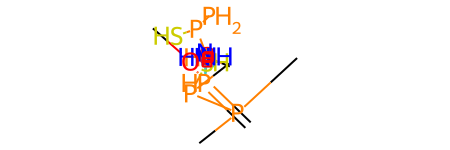

In [41]:
pos = x_i.detach().cpu().tolist()
mol = reconstruct_from_generated(pos, atom_type, atom_aromatic)
mol

In [42]:
mols = []
for i in range(num_graphs):
    index_i = one.batch==i
    x_i = x[Gt_mask][index_i]
    h_i = h[Gt_mask][index_i]
    h_class = torch.argmax(h_i, dim=-1)
    atom_index = h_class.detach().cpu()
    atom_type = get_atomic_number_from_index(atom_index)
    atom_aromatic = is_aromatic_from_index(atom_index)
    pos = x_i.detach().cpu().tolist()
    try:
        mol = reconstruct_from_generated(pos, atom_type, atom_aromatic)
        mols.append(mol)
    except:
        continue

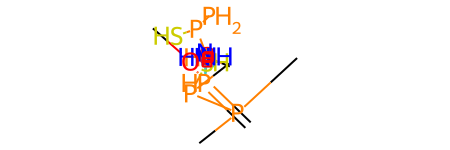

In [43]:
example = mols[0]
example

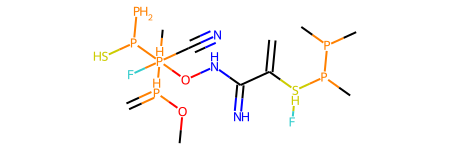

In [44]:
m = Chem.MolFromSmiles(Chem.MolToSmiles(example))
m

In [78]:
with Chem.SDWriter('generated_example.sdf') as w:
  w.write(m)